# 3 Bias correction and thresholding
Many microscope and medical images have an uneven distribution of light, caused by the physical setup of the imaging device, not the speciment. Here we examine a computed tomography image of a rat's head.

It is assumed that the student has completed the previous modules: GettingStarted and VolumeMeasurement. The pedagogical plan is that the student receives the code as a jupyter file, runs each stump, correct possible mistakes, and reflects on the output. Some assignments have been added for the student to test his/hers understanding of the material.

The demonstration uses a slice from a CT image of the head of a rat. For further information, contact Maiken Nedergaard, Section for Translational Neuroscience, University of Copenhagen

# 3.1 Preliminaries
First we setup the Python setting including the libraries, that we are going to use.

In [1]:
from skimage import io, morphology, filters
import numpy as np
from matplotlib import pyplot as plt, cm
plt.rcParams['image.cmap'] = 'gray' # set default colormap for imshow to be gray

We read the image and reduce noise by median filtering.

<class 'numpy.uint16'>
im (mean, min, max): 1017.5518798828125 43 4554


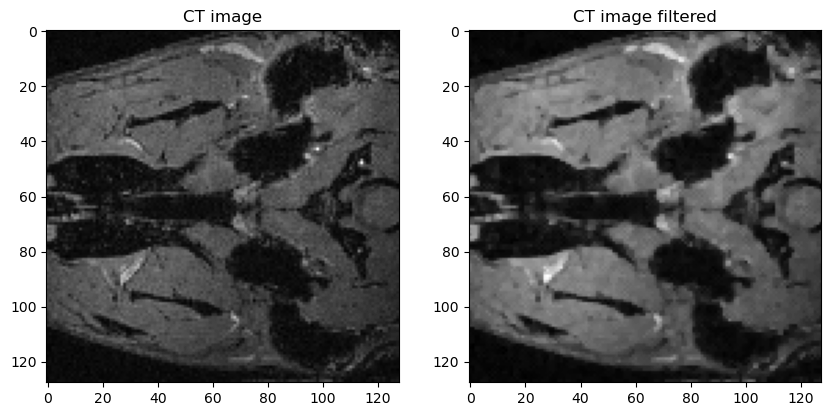

In [2]:
im = io.imread("ratBrainTransverse.tiff")
print(type(im[0,0]))
print("im (mean, min, max):", im.mean(), im.min(), im.max())

dskelm = morphology.disk(1)
imFilt = filters.median(im, dskelm)

fig, ax = plt.subplots(1,2, figsize=(10,5)) # figsize sets size in inches
ax[0].imshow(im)
ax[0].set_title('CT image')
ax[1].imshow(imFilt)
ax[1].set_title('CT image filtered')
plt.show()

In this image, we see that there is an uneven lighting, particularly, it is much darker in the bottom right part of the image. Thresholding the non-cavities is expected to work less well for this reason. Let's examine the histogram and try a number of thresholds.

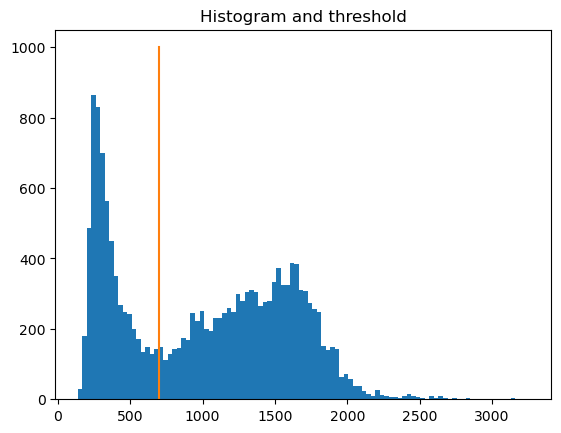

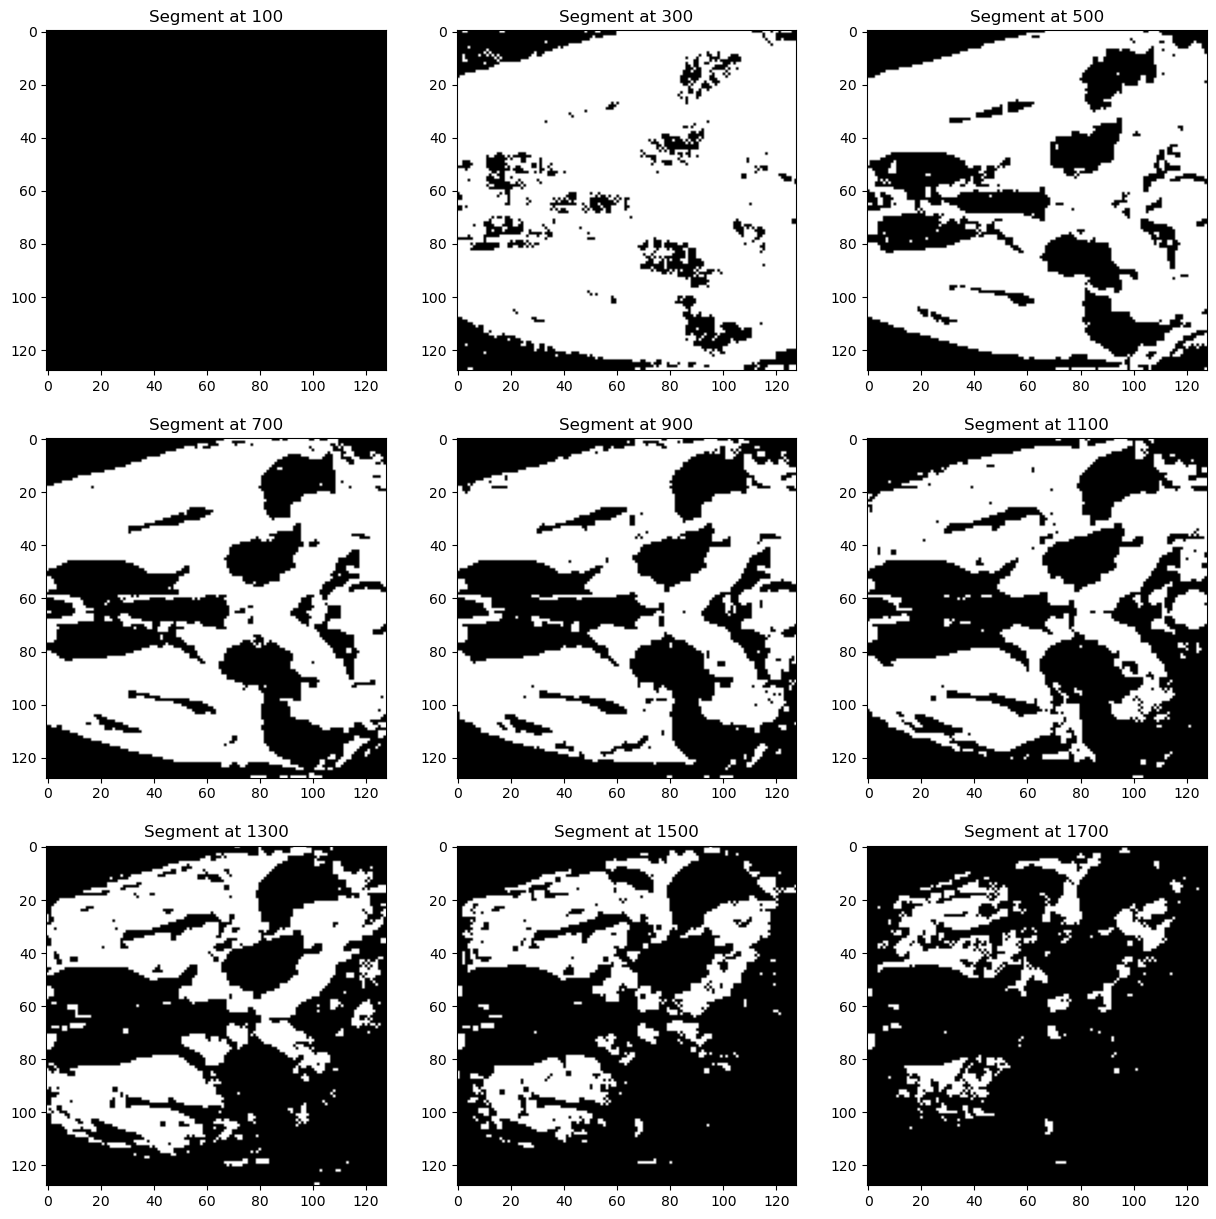

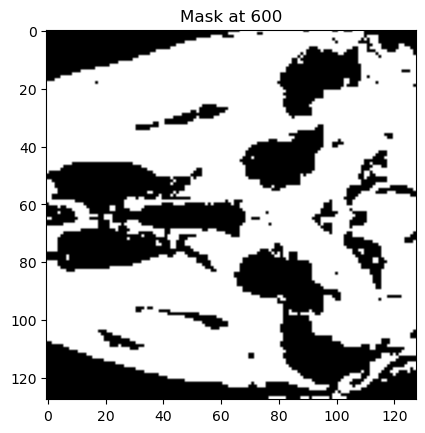

In [3]:
plt.hist(imFilt.flatten(),100)
t = 700
plt.plot([t,t],[0,1000])
plt.title('Histogram and threshold')
plt.show()

step = 200
lst = list(range(100,100+9*step,step))
fig, ax = plt.subplots(3, 3, figsize=(15,15)) # figsize sets size in inches
for i in range(len(lst)):
    s = lst[i]
    brain = imFilt > s
    ax[i//3,i%3].imshow(brain)
    ax[i//3,i%3].set_title('Segment at '+str(s))
plt.show()

tBrain = 600
brain = imFilt > tBrain
plt.imshow(brain)
plt.title('Mask at ' + str(tBrain))
plt.show()

# 3.2 Bias correction
The segmentation is ok, but there is a tradeoff between the fine of detail and the lower right corner. The uneven lighting condition is slowly varying over the image, so we define a function, which fits a second order, two dimensional polynomial to an initial mask. This polynomial we call the bias field.

B (mean, min, max): 1355.7570647468872 460.3302779753312 1596.92078853624


/var/folders/yz/sn2qc9qs7hv31hxnjc_4v9rr0000gn/T/ipykernel_24985/4142339543.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff, residuals, rank, singularValues = np.linalg.lstsq(VanderMondeMsk, ValsMsk)


Text(0.5, 1.0, 'Bias field correted')

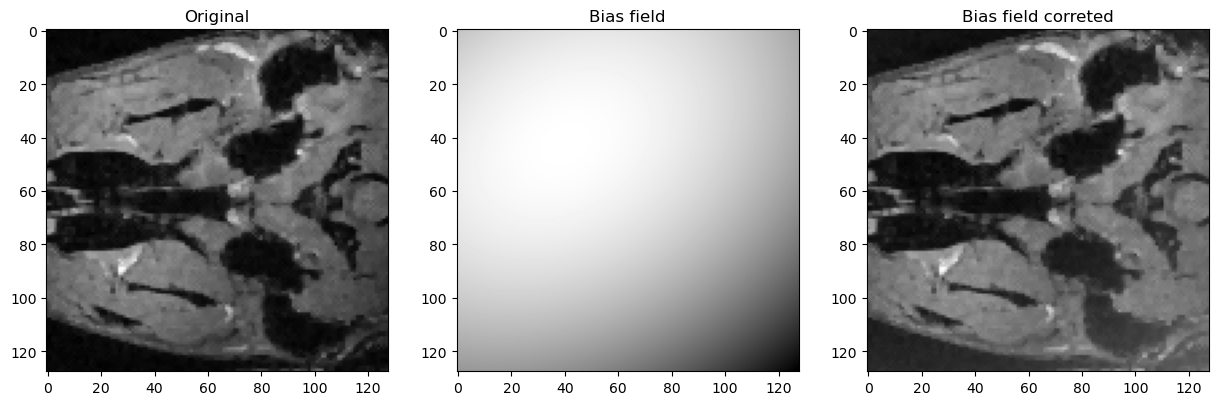

In [4]:
def biasField(I,mask):
    (rows,cols) = I.shape
    r, c = np.meshgrid(list(range(rows)), list(range(cols)))
    rMsk = r[mask].flatten()
    cMsk = c[mask].flatten()
    VanderMondeMsk = np.array([rMsk*0+1, rMsk, cMsk, rMsk**2, rMsk*cMsk, cMsk**2]).T
    ValsMsk = I[mask].flatten()
    coeff, residuals, rank, singularValues = np.linalg.lstsq(VanderMondeMsk, ValsMsk)
    VanderMonde = np.array([r*0+1, r, c, r**2, r*c, c**2]).T
    J = np.dot(VanderMonde, coeff) # @ operator is a python 3.5 feature!
    J = J.reshape((rows,cols)).T
    return(J)

B = biasField(imFilt, brain)
print("B (mean, min, max):", B.mean(), B.min(), B.max())
imBias = imFilt-B+B.mean()
fig, ax = plt.subplots(1, 3, figsize=(15,5)) # figsize sets size in inches
ax[0].imshow(imFilt)
ax[0].set_title('Original')
ax[1].imshow(B)
ax[1].set_title('Bias field')
ax[2].imshow(imBias)
ax[2].set_title('Bias field correted')

The bias field lifts the lower right. We repeat the exercise for finding the threshold.  

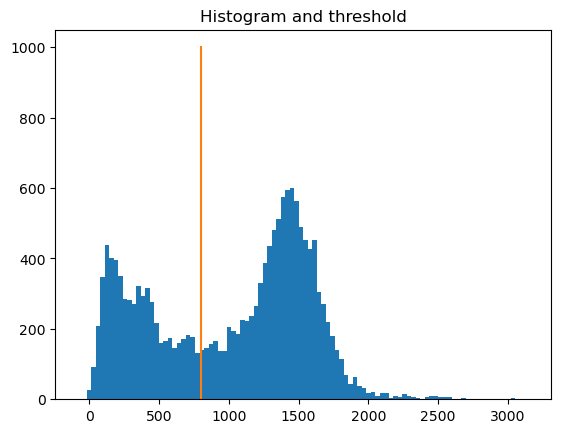

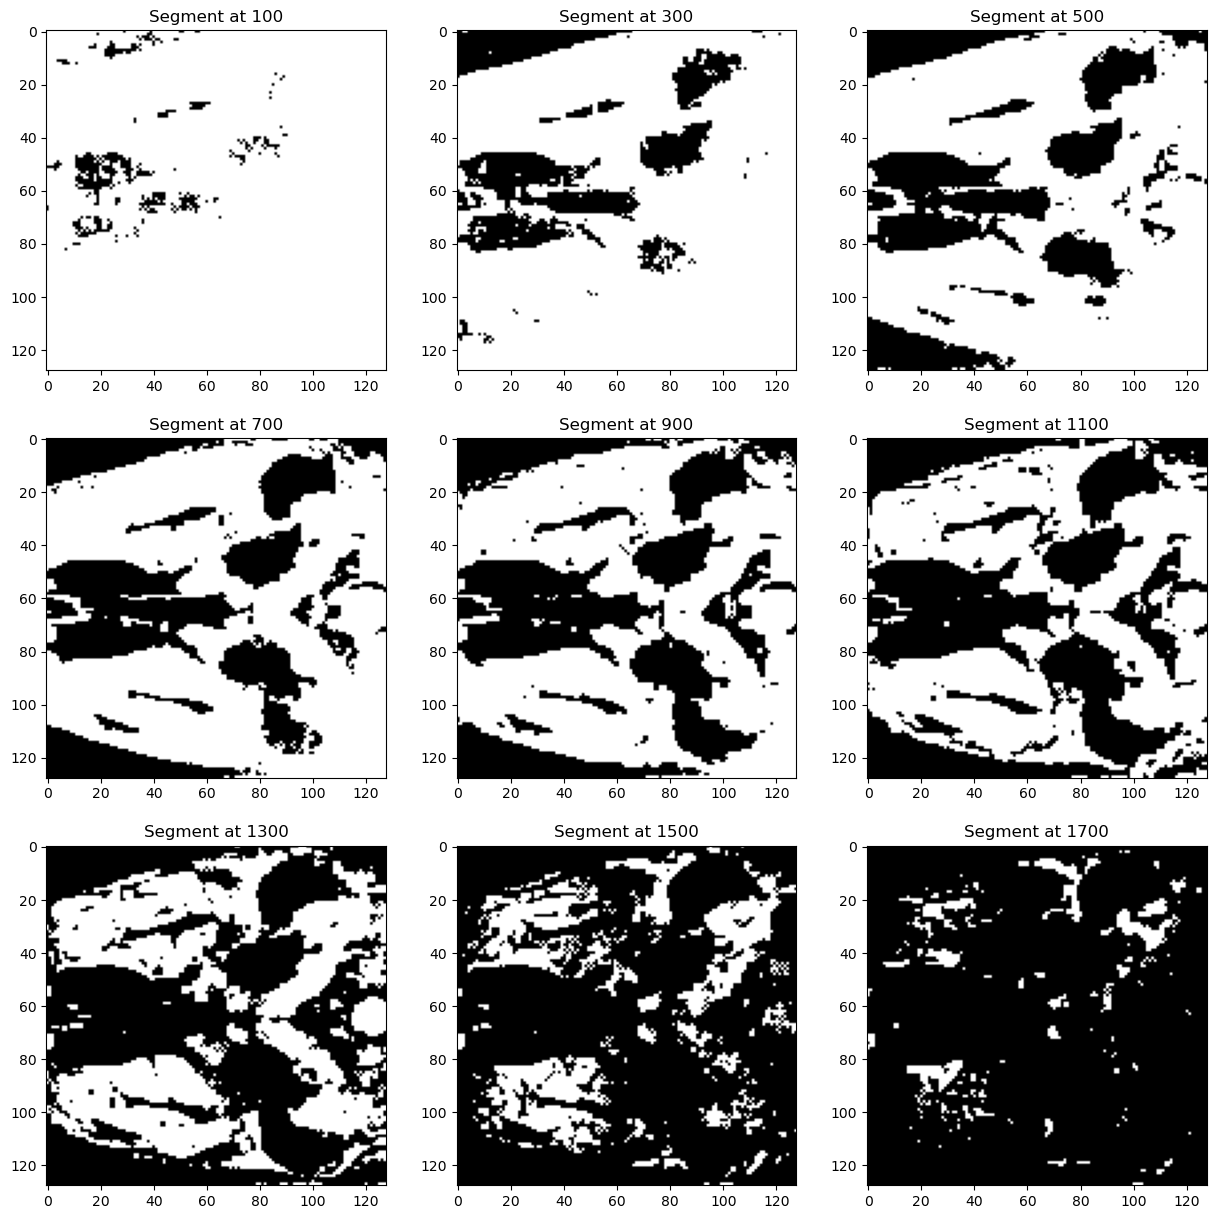

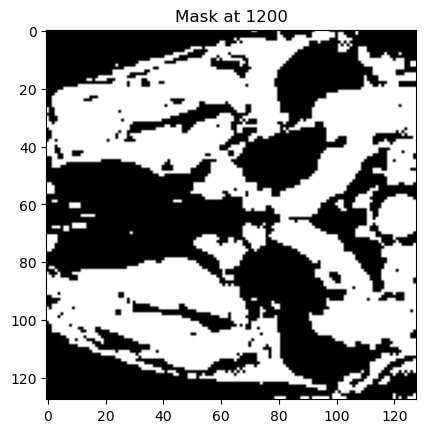

In [5]:
plt.hist(imBias.flatten(),100)
t = 800
plt.plot([t,t],[0,1000])
plt.title('Histogram and threshold')
plt.show()

step = 200
lst = list(range(100,100+9*step,step))
fig, ax = plt.subplots(3, 3, figsize=(15,15)) # figsize sets size in inches
for i in range(len(lst)):
    s = lst[i]
    brainBias = imBias > s
    ax[i//3,i%3].imshow(brainBias)
    ax[i//3,i%3].set_title('Segment at '+str(s))
plt.show()

tBrainBias = 1200
brainBias = imBias > tBrainBias
plt.imshow(brainBias)
plt.title('Mask at ' + str(tBrainBias))
plt.show()

The thresholding is now more symmetric, so now we can compare the segments before and after bias correction.

Text(0.5, 1.0, 'Bias corrected segmented')

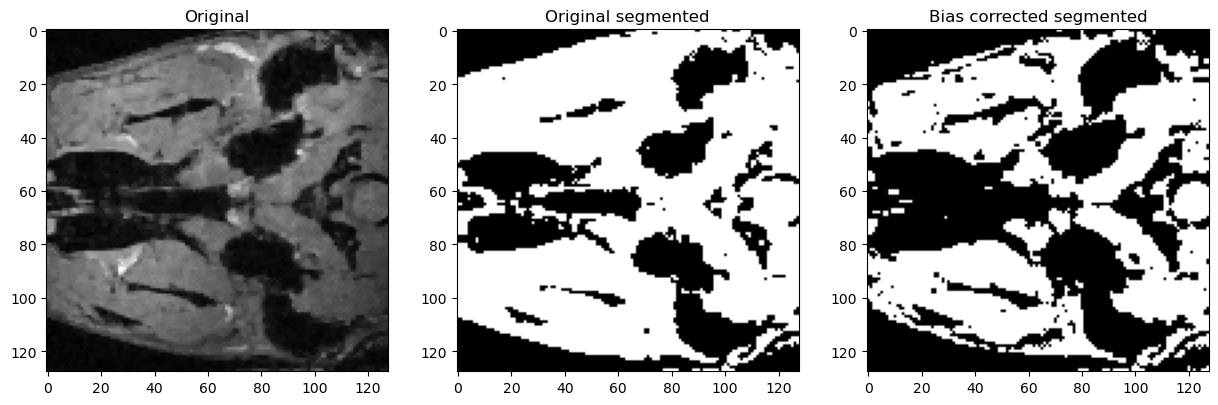

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15,5)) # figsize sets size in inches
ax[0].imshow(imFilt)
ax[0].set_title('Original')
ax[1].imshow(brain)
ax[1].set_title('Original segmented')
ax[2].imshow(brainBias)
ax[2].set_title('Bias corrected segmented')

**Assignment 3a:** Consider the usefulness of the above procedure for bias correction for the image ratBrainSagittal.tiff

**Assigment 3b:** Segment the cavities in the ratBrainTransverse.tiff. Use median filtering and mathematical morphology (dilation, erosion, label) as appropriate.